## Creating a Galaxy Distribution 

### Generating a cosmology with CAMB

Below, we choose a cosmology and generate matter shells and their angular power spectra using glass.shells and camb.

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

# use the CAMB cosmology that generated the matter power spectra
import camb
from cosmology import Cosmology

# GLASS imports: matter, random fields, random points, galaxies
import glass.shells
import glass.fields
import glass.points
import glass.galaxies
import glass.ext.camb


# cosmology for the simulation
h = 0.7
Oc = 0.25
Ob = 0.05

# basic parameters of the simulation
nside = lmax = 128

# set up CAMB parameters for matter angular power spectrum
pars = camb.set_params(H0=100*h, omch2=Oc*h**2, ombh2=Ob*h**2,
                       NonLinear=camb.model.NonLinear_both)

# get the cosmology from CAMB
cosmo = Cosmology.from_camb(pars)

# shells of 200 Mpc in comoving distance spacing
zb = glass.shells.distance_grid(cosmo, 0., 1., dx=200.)

# uniform matter weight function
ws = glass.shells.tophat_windows(zb)

# linear ramp matter weight function
ws_ramp = glass.shells.tophat_windows(zb, weight=glass.ext.camb.camb_tophat_weight)

In [14]:
# compute angular matter power spectra with CAMB
#cls = glass.ext.camb.matter_cls(pars, lmax, ws)
# cls_ramp = glass.ext.camb.matter_cls(pars, lmax, ws_ramp)

# np.save('cls200.npy', cls)
# np.save('cls200ramp.npy', cls_ramp)

### Plotting the window function chosen above 
The window function chosen here is a constant-weight tophat function. In the examples, both this constant weight tophat and the linear ramp tophat are used in order to generate the window function. I am not sure which is better.   

Option A: uniform matter weight function  
`ws = glass.shells.tophat_windows(zb)`
  
Option B: CAMB requires linear ramp for low redshifts  
`ws_ramp = glass.shells.tophat_windows(zb, weight=glass.ext.camb.camb_tophat_weight)`

Text(0, 0.5, 'Window Function Weight')

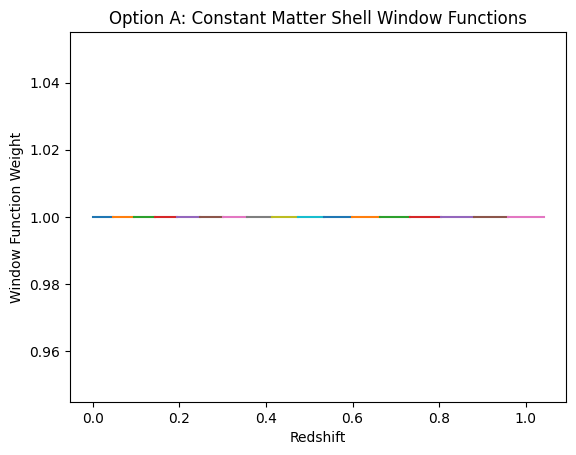

In [16]:
for i in ws:
    plt.plot(i.za, i.wa)
plt.title("Option A: Constant Matter Shell Window Functions")
plt.xlabel("Redshift")
plt.ylabel("Window Function Weight")

Text(0, 0.5, 'Window Function Weight')

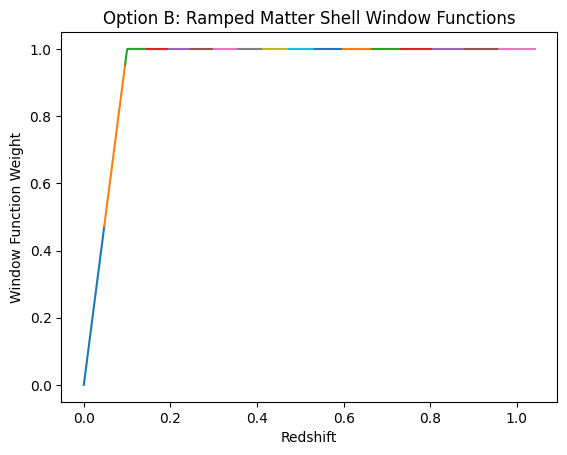

In [17]:
for i in ws_ramp:
    plt.plot(i.za, i.wa)
plt.title("Option B: Ramped Matter Shell Window Functions")
plt.xlabel("Redshift")
plt.ylabel("Window Function Weight")

The ramp seems to be necessary in CAMB for lower redshifts, and then it becomes identical to the constant version. Since Option B is the iterated version, I will use this for the rest of the galaxy distribution generation.

In [18]:
# load the ramped angular matter power spectra previously computed with CAMB
ws = ws_ramp
cls = np.load('cls200ramp.npy')

Here, cls is a $(n(n+1)/2,\text{ lmax})$ array, where lmax is the angular powers and n is the number of shells as determined in glass.shells.distance_grid. The reason that it is $n(n+1)/2$ is that the $C_l$ s are stored as correlations between shells. This includes autocorrelations (one shell with itself), and every other possible correlation (one shell with another). Since we want every combination of shells, we end up with $ n\choose{2} $ = $n(n-1)/2$ $C_l$ arrays. We also add the autocorrelations, which add another n correlations, making it $n(n-1)/2 + n = n(n+1)/2$.